# ITPR1
Pathogenic variation in the ITPR1 gene is associated with

[Gillespie syndrome (GLSP)](https://omim.org/entry/206700), 
[spinocerebellar ataxia-15 (SCA15)](https://omim.org/entry/606658), and
[spinocerebellar ataxia-29 (SCA29)](https://omim.org/entry/117360).

Pathological variants associated with SCA29 have been shown to fall into several mechanistic classes.

- R241K, T267M, T267R, R269G, R269W, S277I, K279E, A280D, E497K: Impair IP3 binding to ITPR1 ([Ando et al. 2018](https://pubmed.ncbi.nlm.nih.gov/30429331/))
- In contrast, V479I, T579I, and N587D did not affect IP3 binding ([Ando et al. 2018](https://pubmed.ncbi.nlm.nih.gov/30429331/))
- Disrupt ITPR1 channel activity without impairing IP3 binding: T579I, N587D ([Ando et al. 2018](https://pubmed.ncbi.nlm.nih.gov/30429331/))
- Two pathological variants, S1478D and V1538M, are located within the CA8 binding site. V1538M completely abolished CA8 binding. Both variants abolish CA8-mediated suppression of ITPR1 activity ([Ando et al. 2018](https://pubmed.ncbi.nlm.nih.gov/30429331/)). V1538M was identified in an individual with SCA29 and S1478D was found in an individual with ataxic cerebral palsy.


    We will follow [Tolonen et al. (2024)](https://pubmed.ncbi.nlm.nih.gov/37964426/) and divide the sequence encoded by NM_001378452.1 (9908nt; 2758 aa) into 
    - Suppresor domain (1-223)
    - IP3 binding: 226-578
    - Regulatory/Coupling: 605-2217
    - Channel: 2227-2758 


In [2]:
import hpotk
import gpsea

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo(release='v2024-08-13')
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2024-08-13
Using gpsea version 0.9.1.dev0


In [3]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator

cohort_name = "ITPR1"	

phenopacket_registry = configure_phenopacket_registry()
with phenopacket_registry.open_phenopacket_store('0.1.20') as ps:
        phenopackets = tuple(ps.iter_cohort_phenopackets(cohort_name))
print(f"{len(phenopackets)} phenopackets imported for {cohort_name}")
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

cohort_creator = configure_caching_cohort_creator(hpo)

cohort, qc = load_phenopackets(
    phenopackets=phenopackets, 
    cohort_creator=cohort_creator,
)
print(f'Loaded {len(cohort)} individuals')
qc.summarize()

170 phenopackets imported for ITPR1
Individuals Processed: 100%|██████████| 170/170 [03:02<00:00,  1.07s/individuals]
Loaded 170 individuals
Validated under permissive policy
No errors or warnings were found


We used the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for *ITPR1*.

In [9]:
ITPR1_MANE_transcript = 'NM_001378452.1'
ITPR1_protein_id = 'NP_001365381.1' # Homo sapiens inositol 1,4,5-trisphosphate receptor type 1 (ITPR1), transcript variant 4, mRNA

In [10]:
from gpsea.view import CohortViewer
cv = CohortViewer(hpo=hpo)
cv.process(cohort=cohort, transcript_id=ITPR1_MANE_transcript)

n,HPO Term
83,Ataxia
75,Hypotonia
57,Nystagmus
56,Delayed ability to sit
54,Dysarthria
54,Delayed ability to walk
53,Delayed speech and language development
49,Global developmental delay
47,Cerebellar atrophy
32,Dysmetria


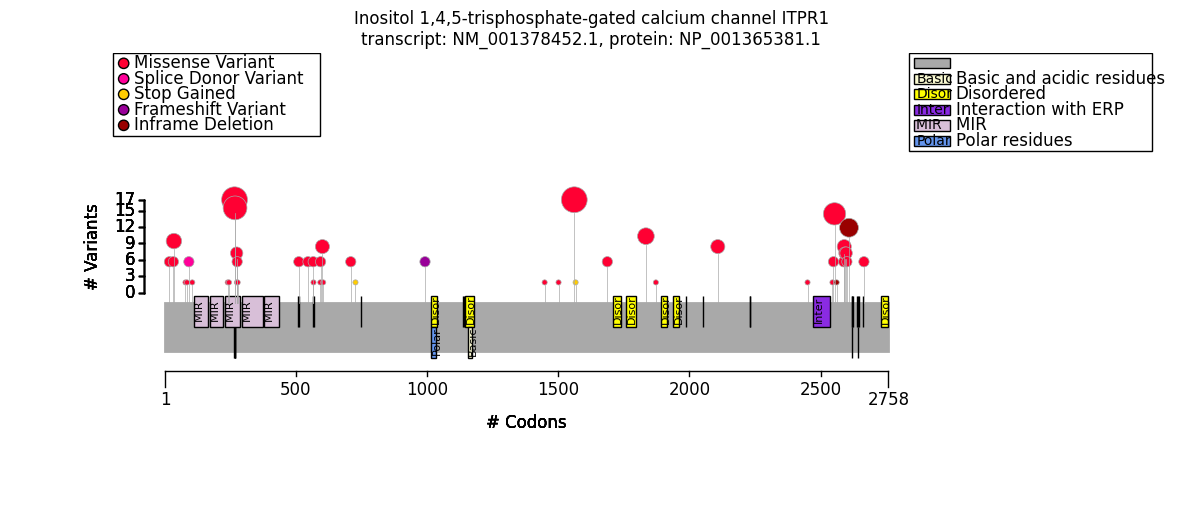

In [11]:
from gpsea.model.genome import GRCh38
from gpsea.preprocessing import configure_default_protein_metadata_service, VVMultiCoordinateService
txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_default_protein_metadata_service()
tx_coordinates = txc_service.fetch(ITPR1_MANE_transcript)
protein_meta = pms.annotate(ITPR1_protein_id)
from gpsea.preprocessing import UniprotProteinMetadataService
from gpsea.model.genome import GRCh38
from gpsea.preprocessing import VVMultiCoordinateService
from gpsea.view import ProteinVisualizable, ProteinVisualizer
pms = UniprotProteinMetadataService()
protein_meta = pms.annotate(ITPR1_protein_id)
txc_service = VVMultiCoordinateService(genome_build=GRCh38)
tx_coordinates = txc_service.fetch(ITPR1_MANE_transcript)
pvis = ProteinVisualizable(tx_coordinates=tx_coordinates, protein_meta=protein_meta, cohort=cohort)
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
fig.savefig('ikzf1_protein_diagram.pdf')  #

In [12]:
from gpsea.view import CohortVariantViewer

viewer = CohortVariantViewer(tx_id=ITPR1_MANE_transcript)
viewer.process(cohort)

Count,Variant key,HGVS,Overlapping Exons,Effects
19,SO:1000029_HGNC:6180_ITPR1,SV involving ITPR1 (p.?),,chromosomal deletion
17,3_4706193_4706193_G_A,c.4684G>A (p.Val1562Met),37,missense
14,3_4645673_4645673_C_T,c.800C>T (p.Thr267Met),10,missense
14,3_4645678_4645678_C_T,c.805C>T (p.Arg269Trp),10,missense
10,3_4814521_4814521_G_A,c.7660G>A (p.Gly2554Arg),58,missense
8,3_4815176_4815179_CAGA_C,c.7831_7833del (p.Lys2611del),59,inframe deletion
6,3_4735314_4735314_T_C,c.5504T>C (p.Leu1835Pro),44,missense
5,3_4521037_4521037_C_T,c.106C>T (p.Arg36Cys),4,missense
4,3_4667467_4667467_A_G,c.1804A>G (p.Asn602Asp),18,missense
3,3_4815132_4815132_T_C,c.7781T>C (p.Phe2594Ser),59,missense


# Hypothesis

  We will follow [Tolonen et al. (2024)](https://pubmed.ncbi.nlm.nih.gov/37964426/) and divide the sequence encoded by NM_001378452.1 (9908nt; 2758 aa) into 
  
  - Suppresor domain (1-223)
  - IP3 binding: 226-578
  - Regulatory/Coupling: 605-2217
  - Channel: 2227-2758 

The authors state: The distribution of variants across different domains of the IP3R1 protein suggests both loss-of-function (LOF) and gain-of-function (GOF) disease mechanisms (Fig. 2) with important implications for therapeutic development. The majority of SCA29 and GLSP cases harbor variants in the IP3-binding and channel domains.

N-Terminal variants are solely associated with SCA29, while C-terminal variants can cause either GLSP (p.Gly2554Arg and p.Lys2611del) or SCA29.

We will also test structural variants against missense variants for association with SCA15.

In [13]:
from gpsea.analysis.predicate import protein_region, variant_key, anyof
from gpsea.model.genome import Region
ip3_region_pred = protein_region(region=Region(start=225, end=578), tx_id=ITPR1_MANE_transcript)

In [14]:
from gpsea.model import VariantEffect

vp = variant_key("3_4645673_4645673_C_T") | variant_key("3_4645678_4645678_C_T")



# The following variants are at or very near IP3 binding pocket
variant_keys = ('3_4645673_4645673_C_T',  ## p.Thr267Met	
                '3_4645673_4645673_C_G', #p.Thr267Arg
                '3_4645678_4645678_C_T', #	p.Arg269Trp'
                '3_4665283_4665283_A_G',#	p.Tyr567Cys
                '3_4663186_4663186_G_A', #	p.Glu512Lys	missense
                '3_4665285_4665285_A_G',#	p.Arg568Gly	missense
                )
compound = anyof(variant_key(key) for key in variant_keys)


In [15]:
from gpsea.analysis.clf import monoallelic_classifier

gt_predicate = monoallelic_classifier(
    a_predicate=compound,
    b_predicate=~compound,
    a_label="IP3 binding",
    b_label="other"
)

In [17]:
from gpsea.analysis.clf import prepare_classifiers_for_terms_of_interest
pheno_predicates = prepare_classifiers_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)
from gpsea.analysis.mtc_filter import HpoMtcFilter
mtc_filter = HpoMtcFilter.default_filter(hpo, term_frequency_threshold=0.5)
mtc_correction = 'fdr_bh'
mtc_alpha = 0.05
from gpsea.analysis.pcats.stats import FisherExactTest
count_statistic = FisherExactTest()

from gpsea.analysis.pcats import HpoTermAnalysis
analysis = HpoTermAnalysis(
    count_statistic=count_statistic,
    mtc_filter=mtc_filter,
    mtc_correction=mtc_correction,
    mtc_alpha=mtc_alpha,
)
result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=gt_predicate,
    pheno_clfs=pheno_predicates,
)

In [19]:
from gpsea.view import MtcStatsViewer
mtc_viewer = MtcStatsViewer()
mtc_viewer.process(result)

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.5,42
HMF02,Skipping term because no genotype has more than one observed HPO count,1
HMF03,Skipping term because of a child term with the same individual counts,2
HMF04,Skipping term because all genotypes have same HPO observed proportions,35
HMF05,Skipping term because one genotype had zero observations,8
HMF06,Skipping term with less than 7 observations (not powered for 2x2),115
HMF08,Skipping general term,59


In [18]:
from gpsea.view import summarize_hpo_analysis

report = summarize_hpo_analysis(hpo=hpo, result=result)
report

Allele group                                       IP3 binding          \
                                                         Count Percent   
Motor delay [HP:0001270]                                 24/24    100%   
Delayed speech and language development [HP:000...       13/13    100%   
Neurodevelopmental delay [HP:0012758]                    29/29    100%   
Nystagmus [HP:0000639]                                   25/26     96%   
Delayed ability to walk [HP:0031936]                     13/13    100%   
Delayed gross motor development [HP:0002194]             18/18    100%   
Delayed ability to sit [HP:0025336]                      11/11    100%   
Hypotonia [HP:0001252]                                   30/30    100%   
Global developmental delay [HP:0001263]                  13/16     81%   
Tremor [HP:0001337]                                      18/18    100%   
Ataxia [HP:0001251]                                      34/34    100%   
Intellectual disability [HP:0001249]                     16/19     84%   
Abnormal muscle tone [HP:0003808]                        31/31    100%   
Neurodevelopmental abnormality [HP:0012759]              31/31    100%   
Cerebellar atrophy [HP:0001272]                          21/22     95%   
Abnormal cerebellum morphology [HP:0001317]              21/21    100%   
Abnormal metencephalon morphology [HP:0011283]           21/21    100%   
Abnormal brain morphology [HP:0012443]                   24/24    100%   
Morphological central nervous system abnormalit...       24/24    100%   
Abnormal communication [HP:0034434]                      18/18    100%   
Abnormal speech pattern [HP:0002167]                     18/18    100%   
Abnormality of coordination [HP:0011443]                 34/34    100%   
Abnormal involuntary eye movements [HP:0012547]          25/25    100%   
Involuntary movements [HP:0004305]                       19/19    100%   

Allele group                                          other          \
                                                      Count Percent   
Motor delay [HP:0001270]                              63/89     71%   
Delayed speech and language development [HP:000...    37/63     59%   
Neurodevelopmental delay [HP:0012758]                 70/90     78%   
Nystagmus [HP:0000639]                                53/78     68%   
Delayed ability to walk [HP:0031936]                  41/68     60%   
Delayed gross motor development [HP:0002194]          57/83     69%   
Delayed ability to sit [HP:0025336]                   42/70     60%   
Hypotonia [HP:0001252]                                56/65     86%   
Global developmental delay [HP:0001263]               35/60     58%   
Tremor [HP:0001337]                                   49/57     86%   
Ataxia [HP:0001251]                                 113/117     97%   
Intellectual disability [HP:0001249]                  44/56     79%   
Abnormal muscle tone [HP:0003808]                     57/57    100%   
Neurodevelopmental abnormality [HP:0012759]           84/84    100%   
Cerebellar atrophy [HP:0001272]                       53/56     95%   
Abnormal cerebellum morphology [HP:0001317]           58/58    100%   
Abnormal metencephalon morphology [HP:0011283]        58/58    100%   
Abnormal brain morphology [HP:0012443]                59/59    100%   
Morphological central nervous system abnormalit...    61/61    100%   
Abnormal communication [HP:0034434]                   69/69    100%   
Abnormal speech pattern [HP:0002167]                  69/69    100%   
Abnormality of coordination [HP:0011443]            113/113    100%   
Abnormal involuntary eye movements [HP:0012547]       53/53    100%   
Involuntary movements [HP:0004305]                    52/52    100%   

Allele group                                                           \
                                                   Corrected p values   
Motor delay [HP:0001270]                                     0.017097   
Delayed s

# Structural variants
todo describe

In [19]:
from gpsea.model import VariantEffect

from gpsea.analysis.predicate import structural_type


sv_deletion = structural_type('SO:1000029') 
gt_predicate = monoallelic_classifier(a_predicate=sv_deletion, b_predicate=~sv_deletion, a_label="SV Deletion", b_label="other")
result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=gt_predicate,
    pheno_clfs=pheno_predicates,
)
from gpsea.view import summarize_hpo_analysis
summary_df = summarize_hpo_analysis(hpo, result)
summary_df

Allele group                                       SV Deletion          \
                                                         Count Percent   
Neurodevelopmental delay [HP:0012758]                     0/19      0%   
Motor delay [HP:0001270]                                  0/19      0%   
Delayed gross motor development [HP:0002194]              0/19      0%   
Delayed ability to walk [HP:0031936]                      0/19      0%   
Delayed speech and language development [HP:000...        0/19      0%   
Delayed ability to sit [HP:0025336]                       0/19      0%   
Global developmental delay [HP:0001263]                   0/19      0%   
Nystagmus [HP:0000639]                                   17/17    100%   
Tremor [HP:0001337]                                      11/11    100%   
Abnormal muscle tone [HP:0003808]                          1/1    100%   
Cerebellar atrophy [HP:0001272]                          15/15    100%   
Abnormal cerebellum morphology [HP:0001317]              15/15    100%   
Abnormal metencephalon morphology [HP:0011283]           15/15    100%   
Abnormal brain morphology [HP:0012443]                   15/15    100%   
Morphological central nervous system abnormalit...       15/15    100%   
Abnormal communication [HP:0034434]                      15/15    100%   
Abnormal speech pattern [HP:0002167]                     15/15    100%   
Ataxia [HP:0001251]                                      19/19    100%   
Abnormality of coordination [HP:0011443]                 19/19    100%   
Abnormal involuntary eye movements [HP:0012547]          17/17    100%   
Involuntary movements [HP:0004305]                       11/11    100%   

Allele group                                          other          \
                                                      Count Percent   
Neurodevelopmental delay [HP:0012758]                99/100     99%   
Motor delay [HP:0001270]                              87/94     93%   
Delayed gross motor development [HP:0002194]          75/82     91%   
Delayed ability to walk [HP:0031936]                  54/62     87%   
Delayed speech and language development [HP:000...    50/57     88%   
Delayed ability to sit [HP:0025336]                   53/62     85%   
Global developmental delay [HP:0001263]               48/57     84%   
Nystagmus [HP:0000639]                                61/87     70%   
Tremor [HP:0001337]                                   56/64     88%   
Abnormal muscle tone [HP:0003808]                     87/87    100%   
Cerebellar atrophy [HP:0001272]                       59/63     94%   
Abnormal cerebellum morphology [HP:0001317]           64/64    100%   
Abnormal metencephalon morphology [HP:0011283]        64/64    100%   
Abnormal brain morphology [HP:0012443]                68/68    100%   
Morphological central nervous system abnormalit...    70/70    100%   
Abnormal communication [HP:0034434]                   72/72    100%   
Abnormal speech pattern [HP:0002167]                  72/72    100%   
Ataxia [HP:0001251]                                 128/132     97%   
Abnormality of coordination [HP:0011443]            128/128    100%   
Abnormal involuntary eye movements [HP:0012547]       61/61    100%   
Involuntary movements [HP:0004305]                    60/60    100%   

Allele group                                                           \
                                                   Corrected p values   
Neurodevelopmental delay [HP:0012758]                    8.553325e-20   
Motor delay [HP:0001270]                                 4.094647e-15   
Delayed gross motor development [HP:0002194]             2.824803e-14   
Delayed ability to walk [HP:0031936]                     7.223639e-12   
Delayed speech and language development [HP:000...       7.223639e-12   
Delayed ability to sit [HP:0025336]                      1.596355e-11   
Global developmental delay [HP:0001263]                  5.417730e-11   
Nystag

In [20]:
from gpsea.analysis.clf import sex_classifier
result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=sex_classifier(),
    pheno_clfs=pheno_predicates,
)
from gpsea.view import summarize_hpo_analysis
summary_df = summarize_hpo_analysis(hpo, result)
summary_df

Sex                                                FEMALE           MALE  \
                                                    Count Percent  Count   
Nystagmus [HP:0000639]                              34/46     74%  19/27   
Neurodevelopmental abnormality [HP:0012759]         50/50    100%  33/33   
Cerebellar atrophy [HP:0001272]                     41/43     95%  27/28   
Abnormal cerebellum morphology [HP:0001317]         44/44    100%  28/28   
Abnormal metencephalon morphology [HP:0011283]      44/44    100%  28/28   
Abnormal brain morphology [HP:0012443]              46/46    100%  29/29   
Morphological central nervous system abnormalit...  47/47    100%  29/29   
Neurodevelopmental delay [HP:0012758]               40/46     87%  23/27   
Ataxia [HP:0001251]                                 59/59    100%  37/37   
Abnormality of coordination [HP:0011443]            59/59    100%  37/37   
Motor delay [HP:0001270]                            35/46     76%  17/22   

Sex                                                                            \
                                                   Percent Corrected p values   
Nystagmus [HP:0000639]                                 70%                1.0   
Neurodevelopmental abnormality [HP:0012759]           100%                1.0   
Cerebellar atrophy [HP:0001272]                        96%                1.0   
Abnormal cerebellum morphology [HP:0001317]           100%                1.0   
Abnormal metencephalon morphology [HP:0011283]        100%                1.0   
Abnormal brain morphology [HP:0012443]                100%                1.0   
Morphological central nervous system abnormalit...    100%                1.0   
Neurodevelopmental delay [HP:0012758]                  85%                1.0   
Ataxia [HP:0001251]                                   100%                1.0   
Abnormality of coordination [HP:0011443]              100%                1.0   
Motor delay [HP:0001270]                               77%                1.0   

Sex                                                           
                                                    p values  
Nystagmus [HP:0000639]                              0.789738  
Neurodevelopmental abnormality [HP:0012759]         1.000000  
Cerebellar atrophy [HP:0001272]                     1.000000  
Abnormal cerebellum morphology [HP:0001317]         1.000000  
Abnormal metencephalon morphology [HP:0011283]      1.000000  
Abnormal brain morphology [HP:0012443]              1.000000  
Morphological central nervous system abnormalit...  1.000000  
Neurodevelopmental delay [HP:0012758]               1.000000  
Ataxia [HP:0001251]                                 1.000000  
Abnormality of coordination [HP:0011443]            1.000000  
Motor delay [HP:0001270]                            1.000000